In [1]:
# from utils.binaries import *
# from utils.plotting import *

from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
def load_file(pickle_location: str):
    with open(pickle_location, 'rb') as f:
        return pickle.load(f)
    
def select_hist(data, bins, cuts, ax=None, **kwargs):

    if ax is None: ax = plt.gca()
    data = np.array(data)
    orientation = kwargs.get('orientation', 'vertical')
    c = kwargs.get('color', 'k')

    select = np.ma.masked_where(((cuts[0] <= data) & (data < cuts[1])), data).mask
    percentage_accept = (1 - (len(data) - sum(select)) / len(data)) * 100
    _ = ax.hist(data, bins=bins, label=f'accept {percentage_accept:.1f}%', histtype='step', align='mid', orientation=orientation, color='k')
    _ = ax.hist(data[select], bins=bins, fc='g', alpha=0.5, align='mid', orientation=orientation, color='k')
    _ = ax.hist(data[~select], bins=bins, fc='r', alpha=0.5, align='mid', orientation=orientation, color='k')

    for cut in cuts:
        if orientation == 'horizontal':
            ax.axhline(cut, ls='-.', alpha=0.2, zorder=0)
        else:
            ax.axvline(cut, ls='-.', alpha=0.2, zorder=0)

    return select

def AddApertureEtcToPlot(ax, unit='mm', filterStructure=True, zorder=10):
    """
    Adds Aperture, Lens, Filterstructure (of most telescopes) to an given axis ax!
    args: axis, unit
    return: nothing
    """
    if unit == 'mm':
        uf = 1
        ax.set_xlabel(r'$x$ / mm')
        ax.set_ylabel(r'$y$ / mm')
    elif unit == 'm':
        uf = 1e-3
        ax.set_xlabel(r'$x$ / m')
        ax.set_ylabel(r'$y$ / m')
    else:
        raise ValueError('Only m and mm are supported!')
    aperture = plt.Circle((0, 0), 1100 * uf, color='tab:red', fill=False, lw=2, zorder=zorder, alpha=0.5)
    ax.add_artist(aperture)
    corrector = plt.Circle((0, 0), 1700 / 2 * uf, color='k', fill=False, ls='--', zorder=zorder)
    if filterStructure:
        ax.plot([-1030 * uf, 1030 * uf], [765 * uf / 2] * 2, color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([-1030 * uf, 1030 * uf], [-765 * uf / 2] * 2, color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([-450 * uf / 2] * 2, [-1078 * uf, 1076 * uf], color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([450 * uf / 2] * 2, [-1078 * uf, 1076 * uf], color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')

        ax.plot([450 * uf / 2 + 460 * uf] * 2, [-850 * uf, 850 * uf], color='grey', alpha=0.3, lw=0.3, zorder=0, ls='solid')
        ax.plot([-450 * uf / 2 - 460 * uf] * 2, [-850 * uf, 850 * uf], color='grey', alpha=0.3, lw=0.3, zorder=0, ls='solid')
    ax.add_artist(corrector)
    ax.set_xlim(-1300 * uf, 1300 * uf)
    ax.set_ylim(-1300 * uf, 1300 * uf)
    ax.set_aspect('equal', 'box')

    return aperture, corrector


    

In [3]:
base = '/home/filip/xy-calibration/QualityControl'

t_led, t_phd = [], []
drift_t_led, drift_t_phd = [], []
noise_phd, drift_phd = [], []
x, y, s = [], [], []
mean_x, mean_y = [], []
cal_a_ratios = []
std_calib_ratios = []
count = 0

for file in os.listdir(base):
    if not file.endswith('.pkl'): continue
    count += 1

    data = load_file(f"{base}/{file}")
    t_led += list(data['t_led'])
    t_phd += list(data['t_phd'])

    drift_t_led.append(np.corrcoef(data['t_led'], data['time'])[0, 1])
    drift_t_phd.append(np.corrcoef(data['t_phd'], data['time'])[0, 1])
    noise_phd.append(np.std(data['phd_signal']) / np.mean(data['phd_signal']))
    drift_phd.append(np.corrcoef(data['phd_signal'], data['time'])[0, 1])

    xs, ys, f = data['flashes']
    x += list(xs)
    y += list(ys) 
    s += list(f / f.max())

    signal_sum = f.sum()
    mean_x.append((xs * f / signal_sum).sum())
    mean_y.append((ys * f / signal_sum).sum())

    cal_a_ratios += list(data['cal_before'] / data['cal_after'])
    std_calib_ratios += list(data['xy_corr'] / data['std_calib'])

/tmp/ipykernel_25066/1827412378.py:35: RuntimeWarning: divide by zero encountered in divide
  std_calib_ratios += list(data['xy_corr'] / data['std_calib'])


Text(0.5, 0, '$T_\\mathrm{Diode}$ / $^\\circ$C')

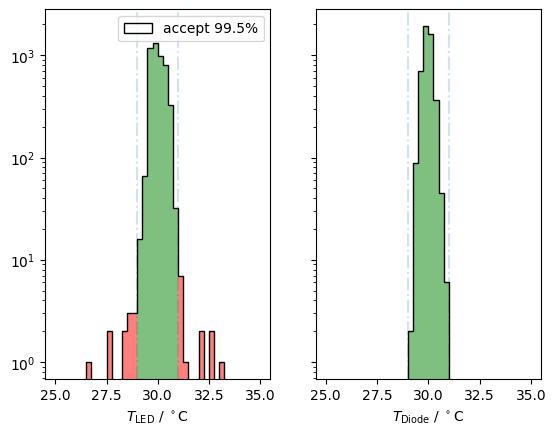

In [4]:
# Temperature

temp_bins = np.linspace(25, 35, 41)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

# _ = ax1.hist(t_led, bins=temp_bins, histtype='step')
_ = select_hist(t_led, temp_bins, [29, 31], ax1, color='k')
ax1.set_yscale('log')
ax1.set_xlabel('$T_\mathrm{LED}$ / $^\circ$C')
ax1.legend()

# _ = ax2.hist(t_phd, bins=temp_bins, histtype='step')
_ = select_hist(t_phd, temp_bins, [29, 31], ax2, color='k')
ax2.set_yscale('log')
ax2.set_xlabel('$T_\mathrm{Diode}$ / $^\circ$C')

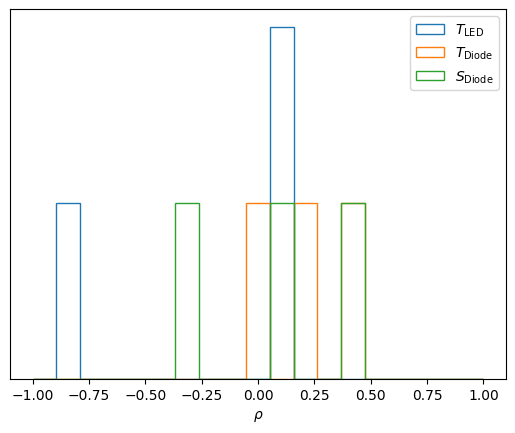

In [5]:
# Drift

drift_bins = np.linspace(-1, 1, 20)

_ = plt.hist(drift_t_led, bins=drift_bins, histtype='step', label=r"$T_\mathrm{LED}$")
_ = plt.hist(drift_t_phd, bins=drift_bins, histtype='step', label=r"$T_\mathrm{Diode}$")
_ = plt.hist(drift_phd, bins=drift_bins, histtype='step', label=r"$S_\mathrm{Diode}$")

plt.xlabel(r'$\rho$')
plt.yticks([])
plt.legend()

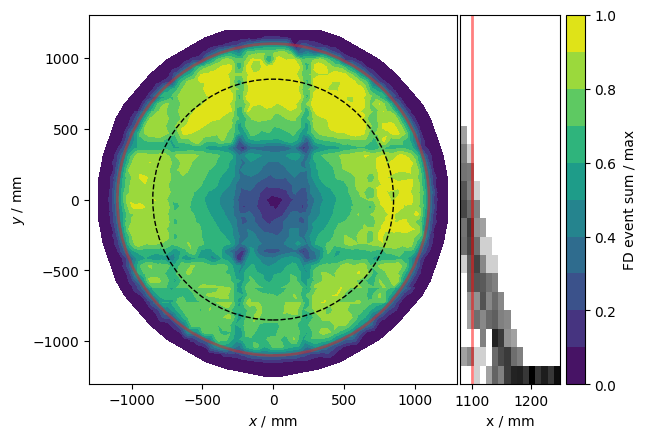

In [6]:
# curtain check

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[1, 0.34])

xi = yi = np.arange(-1300,1300,1)
xi,yi = np.meshgrid(xi,yi)
zi = griddata((x,y),s,(xi,yi),method='linear')

AddApertureEtcToPlot(ax1)
contour = ax1.contourf(xi,yi,zi, np.linspace(0, 1, 11, endpoint=True))

_ = ax2.hist2d(np.sqrt(np.array(x)**2 + np.array(y)**2), s, bins=[120, 20], norm='symlog', cmap='binary')
plt.colorbar(contour, ax=ax2, label='FD event sum / max')
ax2.axvline(1100, c='r', lw=2, alpha = 0.5)
ax2.axvline(850, c='k', ls='--')
ax2.set_xlim(1080)
ax2.set_xlabel('x / mm')
ax2.set_yticks([])
# ax2.set_xscale('log')

plt.subplots_adjust(wspace=0.01)

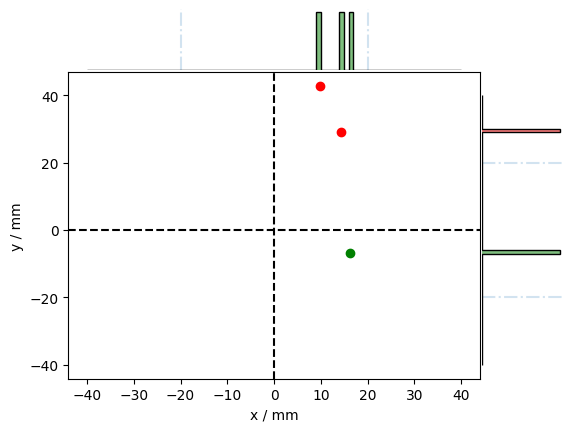

In [7]:
# anisotropy

ani_bins = np.arange(-40, 41, 1)

fig = plt.figure()

gs = GridSpec(
    2, 2,
    width_ratios=[1, 0.2],
    height_ratios=[0.2, 1],
)

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1)

ax2.axis('off')
ax3.axis('off')

sel_x = select_hist(mean_x, ani_bins, [-20, 20], ax2, c='k')
sel_y = select_hist(mean_y, ani_bins, [-20, 20], ax3, c='k', orientation='horizontal')
select_mask = sel_x & sel_y

ax1.scatter(np.array(mean_x)[~select_mask], np.array(mean_y)[~select_mask], c='r')
ax1.scatter(np.array(mean_x)[select_mask], np.array(mean_y)[select_mask], c='g')
ax1.axvline(0, c='k', ls='--')
ax1.axhline(0, c='k', ls='--')
ax1.set_xlabel('x / mm')
ax1.set_ylabel('y / mm')

plt.subplots_adjust(hspace=0.01, wspace=0.01)

([], [])

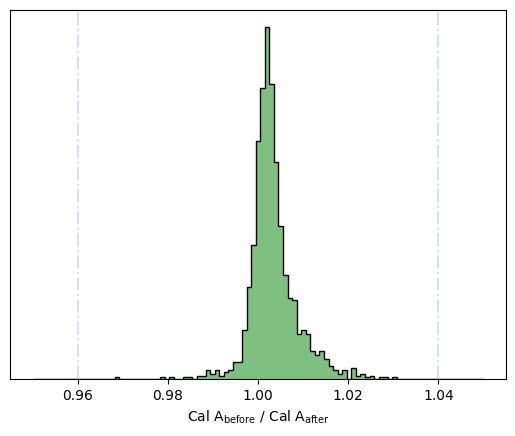

In [10]:
# cal a stability

cal_a_bins = np.linspace(0.95, 1.05, 100)

_ = select_hist(cal_a_ratios, bins=cal_a_bins, cuts=[0.96, 1.04], ax=plt.gca())
plt.xlabel(r'Cal A$_\mathrm{before}$ / Cal A$_\mathrm{after}$')
plt.yticks([])

([], [])

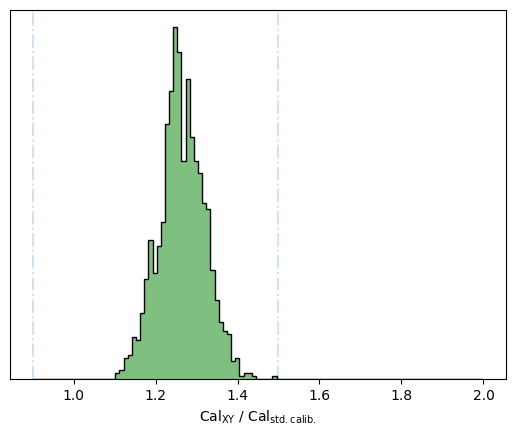

In [11]:
# std. calib

std_calib_bins = np.linspace(0.9, 2.0, 110)

_ = select_hist(std_calib_ratios, bins=std_calib_bins, cuts=[0.9, 1.5])
plt.xlabel(r'Cal$_\mathrm{XY}$ / Cal$_\mathrm{std. calib.}$')
plt.yticks([])